In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#weather_data = pd.read_csv("weather_augment.csv")
#weather_data["timestamp"] = weather_data["timestamp"].astype("datetime64")
weather_test = pd.read_csv("weather_test.csv")
weather_test["timestamp"] = weather_test["timestamp"].astype("datetime64")
#train_data = pd.read_csv("train.csv")
#train_data["timestamp"] = train_data["timestamp"].astype("datetime64")
test_data = pd.read_csv("test.csv")
test_data["timestamp"] = test_data["timestamp"].astype("datetime64")
build_data = pd.read_csv("building_metadata.csv")

In [83]:
train_build = pd.merge(train_data, build_data, on="building_id", how="inner")
train_build_weather = pd.merge(train_build, weather_data, on=["site_id","timestamp"], how="inner")

mergeした後に増える意味がわからない

In [10]:
train_data_xy = train_build_weather[train_build_weather.columns[train_build_weather.columns != 'Unnamed: 0']]

In [11]:
train_data_xy["timestamp_convert"] = pd.to_datetime(train_data_xy["timestamp"], format='%Y%m%d %H:%M')
train_data_xy = train_data_xy.set_index("timestamp_convert") 

In [12]:
train_data_xy = train_data_xy.drop("timestamp", axis=1)

In [13]:
train_data_xy = train_data_xy.set_index([train_data_xy.index.month, train_data_xy.index.day, train_data_xy.index.hour])
train_data_xy.index.names = ["month", 'day', "hour"]

In [14]:
train_data_xy = train_data_xy.reset_index()

## トレインとバリッド、テストに分割
分割する際には、層別サンプリングを行う。テストとトレインで分布が似ている特徴量(メーターの種類)と目的変数

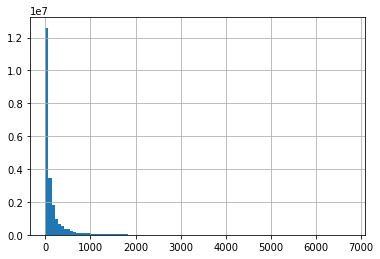

In [17]:
train_data_xy["meter_reading"].hist(bins=100)
plt.show()

In [18]:
train_data_xy["meter_reading"].nunique()

184460

ユニーク数が多すぎるので、この数をそのままラベルにすることはできない。

In [19]:
bins_boundary = [-0.001, 0,15,38,75,135,300,10000]
labels=["0", "1", "2", "3", "4" ,"5", "6"]

In [20]:
train_data_xy["meter_reading_rank"] = pd.cut(train_data_xy["meter_reading"], bins=bins_boundary, labels=labels)

In [21]:
train_data_xy["meter_reading_rank"].value_counts()

0    3587536
2    3327136
5    3139760
1    3111520
6    3083936
3    3075664
4    2954384
Name: meter_reading_rank, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
#train, test = train_test_split(train_data_xy, test_size=0.3, random_state=100,
#                                                    stratify=train_data_xy[["building_id", "meter", "meter_reading_rank"]])
train, test = train_test_split(train_data_xy, test_size=0.3, random_state=100,
                                                    stratify=train_data_xy["meter_reading_rank"])


#valid, test_final = train_test_split(test, test_size=0.5, random_state=100,
#                                                    stratify=test[["building_id", "meter", "meter_reading_rank"]])
valid, test_final = train_test_split(test, test_size=0.5, random_state=100,
                                                    stratify=test["meter_reading_rank"])

In [25]:
train_data_xy.nunique()

month                     12
day                       31
hour                      24
building_id              743
meter                      3
meter_reading         184460
site_id                    6
primary_use               15
square_feet              705
year_built               110
floor_count               15
air_temperature          264
cloud_coverage             6
dew_temperature          230
precip_depth_1_hr         37
sea_level_pressure       389
wind_direction            37
wind_speed                32
meter_reading_rank         7
dtype: int64

## データをcsvとして保存する。

In [109]:
train = train.drop("meter_reading_rank", axis=1)
valid = valid.drop("meter_reading_rank", axis=1)
test_final = test_final.drop("meter_reading_rank", axis=1)

In [110]:
train.to_csv("train_modeling.csv")
valid.to_csv("valid_modeling.csv")
test_final.to_csv("test_modeling.csv")

## テストデータを作成するための関数を作成

In [3]:
def convert_type(data):
    for c in data.columns:
        col_type = data[c].dtype
        if col_type.name == 'float':
            data[c] = data[c].astype('float16')
        if col_type.name == 'int':
            data[c] = data[c].astype('int8')
    return data

In [4]:
def make_modeling(data, build_data, weather_data):
    data = convert_type(data)
    build_data = convert_type(build_data)
    weather_data = convert_type(weather_data)
    data_build = pd.merge(data, build_data, on="building_id", how="inner")
    data_build_weather = pd.merge(data_build, weather_data, on=["site_id","timestamp"], how="inner")
    data_xy = data_build_weather[data_build_weather.columns[data_build_weather.columns != 'Unnamed: 0']]
    data_xy["timestamp_convert"] = pd.to_datetime(data_xy["timestamp"], format='%Y%m%d %H:%M')
    data_xy = data_xy.set_index("timestamp_convert") 
    data_xy = data_xy.drop("timestamp", axis=1)
    data_xy = data_xy.set_index([data_xy.index.month, data_xy.index.day, data_xy.index.hour])
    data_xy.index.names = ["month", 'day', "hour"]
    data_xy = data_xy.reset_index()
    return data_xy

In [4]:
test_data = convert_type(test_data)
build_data = convert_type(build_data)
weather_test = convert_type(weather_test)

In [5]:
test_build = pd.merge(test_data, build_data, on="building_id", how="inner")

In [14]:
test_build.nunique()

row_id         41697600
building_id        1449
meter                 4
timestamp         17520
site_id              16
primary_use          16
square_feet        1397
year_built          116
floor_count          18
dtype: int64

In [6]:
test_build.shape

(41697600, 9)

一旦、各"row_id"から一つずつサンプリングすることにする。

In [ ]:
data_build_weather = pd.merge(test_build, weather_test, on=["site_id","timestamp"], how="inner")

In [ ]:
data_build_weather.nunique()

In [13]:
weather_test.nunique()

site_id                  16
timestamp             17520
air_temperature         639
cloud_coverage           10
dew_temperature         559
precip_depth_1_hr       174
sea_level_pressure      717
wind_direction           60
wind_speed               78
dtype: int64

- 天気情報は、730日×24時間分のユニーク数はあるが、全てのsite_idに対して730日×24時間分のデータがあるかどうかは不明
- ビルの数とメーターの種類の組み合わせ数は2380組み

In [ ]:
data_build_weather.nunique()

In [50]:
id_count = pd.DataFrame(data_build_weather["row_id"].value_counts())

In [51]:
count_1 = list(id_count[id_count["row_id"]==1].index)

In [52]:
count_other = list(id_count[id_count["row_id"]!=1].index)

In [53]:
data_build_weather_count1 = data_build_weather[data_build_weather["row_id"].isin(count_1)]

In [54]:
data_build_weather_count_other = data_build_weather[data_build_weather["row_id"].isin(count_other)]

In [55]:
data_build_weather_count_other_unique = data_build_weather_count_other[~data_build_weather_count_other.duplicated(subset=["row_id", "building_id", "meter", "timestamp", "site_id"], keep='last')]

In [56]:
data_concat = pd.concat([data_build_weather_count1,data_build_weather_count_other_unique], axis=0) 

In [57]:
data_xy = data_concat[data_concat.columns[data_concat.columns != 'Unnamed: 0']]

In [59]:
data_xy = data_xy.set_index("timestamp") 

In [60]:
data_xy = data_xy.set_index([data_xy.index.month, data_xy.index.day, data_xy.index.hour])

In [61]:
data_xy.index.names = ["month", 'day', "hour"]

In [62]:
data_xy = data_xy.reset_index()

In [75]:
data_xy_fill = data_xy.fillna(method="ffill")

In [76]:
data_xy_fill2 = data_xy_fill.fillna(method="backfill")

In [79]:
data_xy_fill2.to_csv("submit_test.csv")

In [63]:
test_data["building_id"].nunique()

1449

In [78]:
data_xy_fill2.nunique()

month                      12
day                        31
hour                       24
row_id                2471700
building_id               793
meter                       4
site_id                    11
primary_use                16
square_feet               783
year_built                 74
floor_count                12
air_temperature           497
cloud_coverage             10
dew_temperature           461
precip_depth_1_hr          86
sea_level_pressure        544
wind_direction             38
wind_speed                 43
dtype: int64